In [1]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

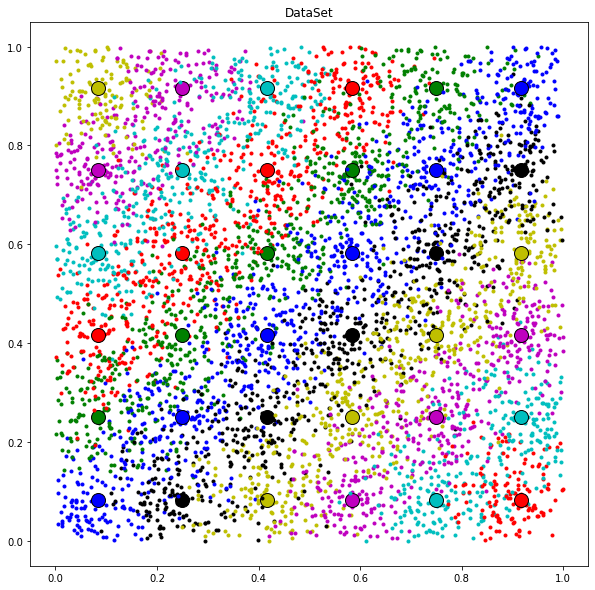

In [14]:
grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

In [7]:
save_obj([samples, true_sample_membership, true_centroids],'test')

In [8]:
samples, true_sample_membership, true_centroids = load_obj('test')

In [ ]:
sample_weights = np.full(n_samples, 1.0)

In [7]:
grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

#samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

#if n_features == 2:
#    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

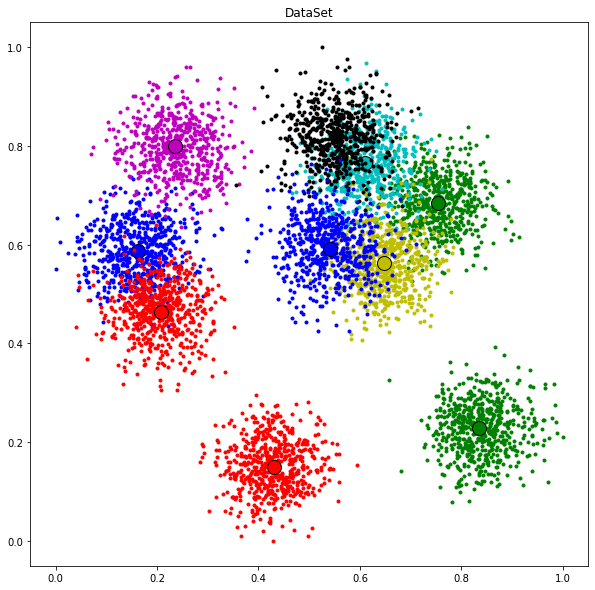

In [6]:
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = gaussian_blobs(n_features, n_samples, n_cluster, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

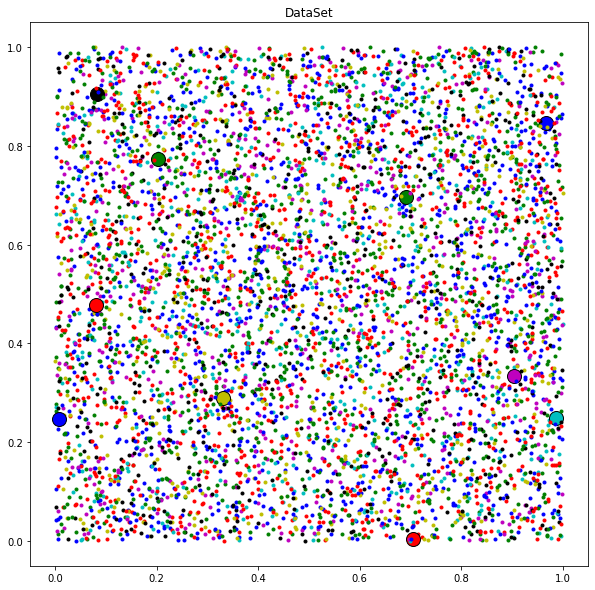

In [4]:
n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [15]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 24.11344851101005

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.33 ms


# Initialization by Random Centroids

In [16]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 59.50011265565776

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 2.22 ms


# Initialization by K-Means++

In [17]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 32.28981869758018

CPU times: user 80 ms, sys: 24 ms, total: 104 ms
Wall time: 21.3 ms


# K-Means initialized by True Centroids

In [18]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.33195368054227
Iterations: 27
Clusters: 36

CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 13.7 ms


# K-Means initialized by K-Means++ with sample_objectives as weights

In [19]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.49995343805968
Iterations: 53
Clusters: 36



# K-Means initialized by Random Centroids

In [20]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.808257113486704
Iterations: 28
Clusters: 36

CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 15.4 ms


# K-Means initialized by K-Means++

In [21]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.73439242024735
Iterations: 51
Clusters: 36

CPU times: user 176 ms, sys: 16 ms, total: 192 ms
Wall time: 38.7 ms


# K-Means initialized by K-Means++ (sklearn)

In [22]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 23.962127502951756
Iterations: 32
CPU times: user 340 ms, sys: 40 ms, total: 380 ms
Wall time: 150 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [23]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.314482153882107
Iterations: 17
Clusters: 36

CPU times: user 112 ms, sys: 8 ms, total: 120 ms
Wall time: 118 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [24]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.881458584050144
Iterations: 23
Clusters: 36

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 141 ms


# H-Means initialized by Random Membership Distribution

In [25]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.890788915544857
Iterations: 28
Clusters: 36

CPU times: user 352 ms, sys: 8 ms, total: 360 ms
Wall time: 356 ms


# K-H-Means initialized by True Centroids

In [26]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.281117282938432
Iterations: 49
Clusters: 36

CPU times: user 260 ms, sys: 16 ms, total: 276 ms
Wall time: 208 ms


# K-H-Means initialized by K-Means++

In [27]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.867546860621598
Iterations: 78
Clusters: 36

CPU times: user 188 ms, sys: 32 ms, total: 220 ms
Wall time: 123 ms


# Simple Membership Shaking VNS

In [28]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 300
k_max_iters = 300
h_tol = 0.05
k_tol = 0.0001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.735743767243434
Iterations: 37
Clusters: 36

objective                     k      n_iters        n_iters_k      cpu_time       
23.721007                     1      0              0              0.01           
23.715269                     1      1              0              0.02           
23.713859                     1      2              0              0.03           
23.710984                     1      3              0              0.04           
23.708233                     1      4              0              0.05           
23.707710                     1      5              0              0.06           
23.707629                     1      6              0              0.07           
23.707609                     3      15             2              0.16           
23.707609                     3      18             2              0.19           
23.706718                     1      19             2              0.20           
23.706603                   

# Solution Visualization

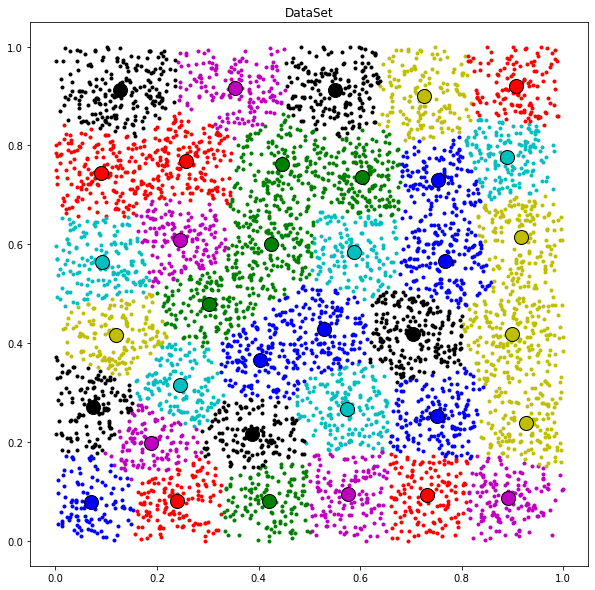

In [29]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [31]:
%%time

# k_max_iters = 50
# k_tol=0.01
k_max_iters = 300
k_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.839207196996945
Iterations: 65
Clusters: 36

objective                     n_iters        cpu_time       
23.501996                     2              0.18           
23.332585                     5              0.27           
23.330429                     59             1.98           
23.329819                     69             2.30           
23.274978                     122            4.00           
23.274951                     196            6.32           
23.271832                     219            7.04           
23.271832                     339            10.00          

Objective: 23.271832043917165
Global Iterations: 339
Local Iterations: 14
Clusters: 36

CPU times: user 1min 10s, sys: 9.32 s, total: 1min 20s
Wall time: 10.1 s


# Solution Visualization

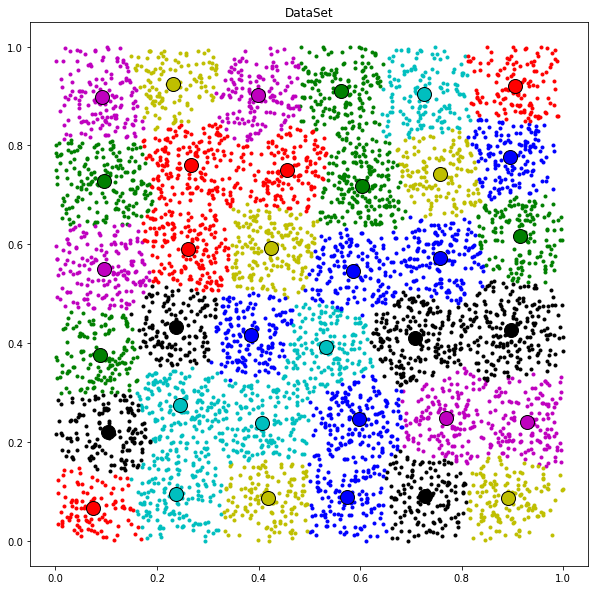

In [32]:
draw_dataset(samples, centroids, sample_membership)

# Center Shaking VNS

In [34]:
%%time

shaking_mode = 0
fully_random = False
kmax = 10

local_max_iters = 300
local_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol, True)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, shaking_mode, fully_random, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.557831859811284
Iterations: 24
Clusters: 36

objective                     k      n_iters        n_iters_k      cpu_time       
23.549423                     1      0              0              0.02           
23.544971                     1      1              0              0.03           
23.518788                     1      2              0              0.04           
23.507906                     2      4              0              0.06           
23.494955                     8      12             0              0.16           
23.473928                     2      14             0              0.18           
23.424048                     2      16             0              0.20           
23.399037                     9      25             0              0.32           
23.380711                     1      26             0              0.33           
23.374531                     1      27             0              0.33           
23.366317                   

# Solution Visualization

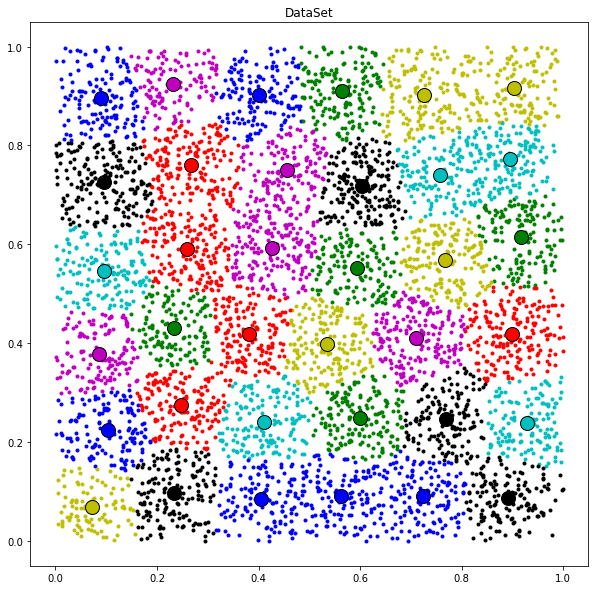

In [35]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [37]:
%%time

printing=True
local_max_iters=300
local_tol=0.0001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds
shaking_mode = 0


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, shaking_mode, printing)

K-means:
24.182036228886663

Center Shaking VNS:
objective                     k      n_iters        n_iters_k      cpu_time       
24.142513                     1      0              0              0.03           
24.141018                     1      1              0              0.03           
23.767584                     1      2              0              0.07           
23.432575                     3      5              0              0.11           
23.422853                     3      13             1              0.20           
23.393240                     1      14             1              0.21           
23.373752                     2      16             1              0.23           
23.314471                     3      24             2              0.30           
23.305935                     1      25             2              0.31           
23.302295                     1      26             2              0.32           
23.291089                     2      3

# Solution Visualization

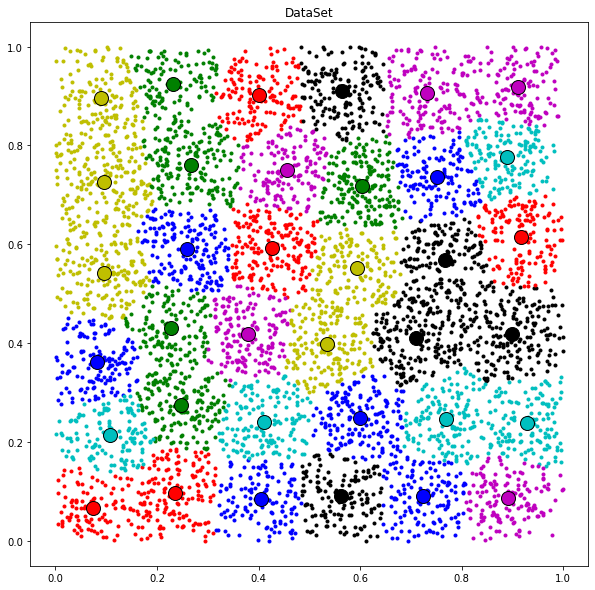

In [38]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [42]:
%%time

portion_size = 1000
n_portions = 10
init_method = 1
local_max_iters = 300
local_tol = 0.0001
max_cpu_time = 3
max_iters = 300
n_candidates = 3
aggregation_method = 1
basis_n_init = 3


method_sequence = np.array([0, 4, 5, 4, 5, 3])
kmax_sequence = np.array([0,5,5,5,15,0])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

# method_sequence = np.array([4])
# kmax_sequence = np.array([5])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

# method_sequence = np.array([0])
# kmax_sequence = np.array([5])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)

print(objective)

23.262852796137373
CPU times: user 1min 52s, sys: 36.9 s, total: 2min 29s
Wall time: 26.7 s
